# Set up

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

from matplotlib.patches import Wedge, Circle

# Read Data

In [2]:
X_train = pd.read_csv("../Data/X_train.csv").values
X_test = pd.read_csv("../Data/X_test.csv").values

# Create Data

In [3]:
low_bound, high_bound = 0.1, 5.0
BASELINE = 1.0
LOW, HIGH = low_bound, high_bound
REPLICATES_PER_REGION = 20

In [4]:
def build_datasets_for_centre(m, seed,
                              sd2=1, rho=-0.3,
                              baseline_jitter=5e-1,
                              jitter_mode="random",
                              n_active_regions=1):
    rng = np.random.default_rng(seed)

    sd = np.sqrt(sd2)
    cov = np.array([[sd**2,       rho*sd**2],
                    [rho*sd**2,   sd**2     ]])

    rows = []
    all_regions = list(range(1, 6))

    for region in all_regions:
        for _ in range(REPLICATES_PER_REGION):
            mean = np.array([m, m])


            active_regions = [region]
            if n_active_regions > 1:
                others = [r for r in all_regions if r != region]
                extra = rng.choice(others, size=n_active_regions - 1,
                                   replace=False)
                active_regions.extend(extra)


            samples = {}
            for r_act in active_regions:
                while True:
                    x = rng.multivariate_normal(mean, cov)
                    if LOW <= x[0] <= HIGH and LOW <= x[1] <= HIGH:
                        samples[r_act] = x
                        break


            params = []
            for r in all_regions:
                if r in active_regions:

                    a_r, b_r = samples[r]
                    params.extend([a_r, b_r])
                else:

                    if jitter_mode == "random":

                        theta = rng.uniform(0.0, 2.0 * np.pi)
                        rad = baseline_jitter * np.sqrt(rng.uniform(0.0, 1.0))
                        a_r = BASELINE + rad * np.cos(theta)
                        b_r = BASELINE + rad * np.sin(theta)
                        params.extend([a_r, b_r])
                    else:

                        params.extend([BASELINE, BASELINE])

            rows.append(params)

    return pd.DataFrame(
        rows,
        columns=[f"{ab}{r}" for r in range(1, 6) for ab in ("a", "b")]
    )

In [5]:
def avg_knn_distance(X, ref, k=100):
    # X: (M,d), ref: (N,d)
    diff = X[:, None, :] - ref[None, :, :]
    dist2 = np.sum(diff**2, axis=2)
    dist = np.sqrt(dist2)
    nearest = np.partition(dist, k-1, axis=1)[:, :k]
    return nearest.mean(axis=1)

In [11]:
m_values = [1.5, 2.0, 2.5, 3.5, 4.0]
all_avg_dists = []

for i, m in enumerate(m_values):
    df_m = build_datasets_for_centre(
        m=m,
        sd2=0.5,
        rho=0.3,
        baseline_jitter=5e-2,
        jitter_mode="random",
        n_active_regions=1,
        seed=1000 + i,  # 每个 m 换个 seed
    )
    X_m = df_m.to_numpy()
    avg_dist_m = avg_knn_distance(X_m, X_train, k=100)
    all_avg_dists.append(avg_dist_m)

    print(f"m={m:.1f}: mean={avg_dist_m.mean():.4f}, std={avg_dist_m.std():.4f}")

m=1.5: mean=3.4602, std=0.1181
m=2.0: mean=3.3812, std=0.0913
m=2.5: mean=3.3450, std=0.0585
m=3.5: mean=3.4577, std=0.1270
m=4.0: mean=3.5516, std=0.1363


In [13]:
df_m = build_datasets_for_centre(2, sd2=0.5, baseline_jitter=5e-2, seed=1000+i)

In [ ]:
df_m

C:\Users\r4718\AppData\Local\Temp\ipykernel_11328\1909293339.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


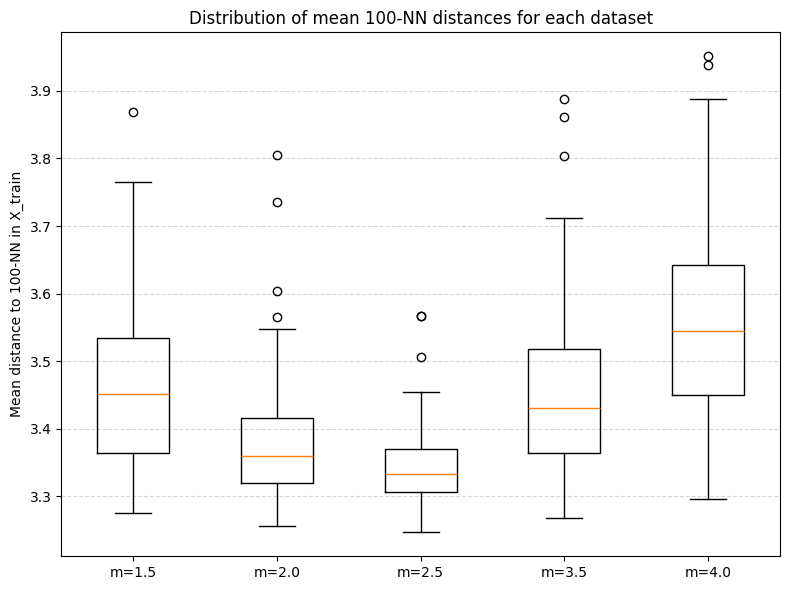

In [12]:
data = all_avg_dists
labels = [f"m={m}" for m in m_values]

plt.figure(figsize=(8, 6))
plt.boxplot(
    data,
    labels=labels,
)

plt.ylabel("Mean distance to 100-NN in X_train")
plt.title("Distribution of mean 100-NN distances for each dataset")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Plot segment

In [57]:
def plot_bullseye(ax, values, cmap='viridis', vmin=None, vmax=None):

    values = np.asarray(values)

    if vmin is None:
        vmin = float(values.min())
    if vmax is None:
        vmax = float(values.max())


    r = [0.0, 1.0, 2.0, 3.0, 4.0]

    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)


    # angles6 = np.linspace(120, 480, 7)
    angles6 = np.linspace(-480, -120, 7)
    idx = 0
    for i in range(6):
        th1, th2 = angles6[i], angles6[i+1]
        color = sm.to_rgba(values[idx]); idx += 1
        w = Wedge(
            (0, 0), r[4], th1, th2,
            width=r[4]-r[3],
            facecolor=color, edgecolor='black', linewidth=1
        )
        ax.add_patch(w)


    for i in range(6):
        th1, th2 = angles6[i], angles6[i+1]
        color = sm.to_rgba(values[idx]); idx += 1
        w = Wedge(
            (0, 0), r[3], th1, th2,
            width=r[3]-r[2],
            facecolor=color, edgecolor='black', linewidth=1
        )
        ax.add_patch(w)


    angles4 = np.linspace(-495, -135, 5)
    for i in range(4):
        th1, th2 = angles4[i], angles4[i+1]
        color = sm.to_rgba(values[idx]); idx += 1
        w = Wedge(
            (0, 0), r[2], th1, th2,
            width=r[2]-r[1],
            facecolor=color, edgecolor='black', linewidth=1
        )
        ax.add_patch(w)


    color = sm.to_rgba(values[idx]); idx += 1
    c = Circle((0, 0), r[1], facecolor=color,
               edgecolor='black', linewidth=1)
    ax.add_patch(c)


    ax.set_xlim(-4.1, 4.1)
    ax.set_ylim(-4.1, 4.1)
    ax.set_aspect('equal')
    ax.axis('off')

    return sm



In [15]:
Y_data_2 = pd.read_csv('simulation_results_X_2.txt', header=None, delimiter=' ')
Y_data_2 = Y_data_2.drop(columns=[Y_data_2.columns[-1]])

In [59]:
values_20 = Y_data_2.iloc[:20,1:].values

In [36]:
Y_data_2.iloc[20:40,1:].values.shape

(20, 51)

In [60]:
mean_51 = values_20.mean(axis=0)
mean_3x17 = mean_51.reshape(3, 17)
mean_cir, mean_rad, mean_long = mean_3x17

total_strain_17 = np.sqrt(mean_cir**2 + mean_rad**2 + mean_long**2)

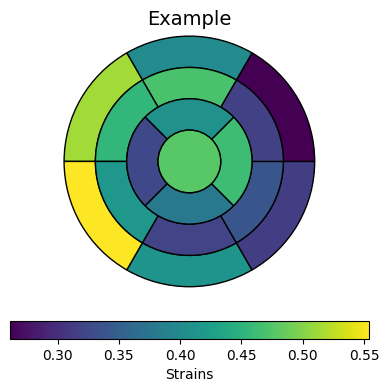

In [61]:
values = total_strain_17

fig, ax = plt.subplots(figsize=(4, 4))
sm = plot_bullseye(ax, values, cmap="viridis")
ax.set_title("Example", fontsize=14)

# 单独一条 colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal',
                    fraction=0.07, pad=0.1)
cbar.set_label("Strains")

plt.tight_layout()
plt.show()